I will try to model the US GDP, using time series analysis

In [1]:
import pandas as pd
import quandl
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import het_arch
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error as mape
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import my function 
import sys
sys.path.insert(0, '/Users/user/PycharmProjects/Py_and_R')
from Package import Arima_garch_forecasts

In [3]:
#import GDP data from FRED
df = quandl.get(dataset="FRED/GDP",  start_date='1950-01-01', end_date='2021-12-31', collapse = 'annual')
df = df.reset_index()

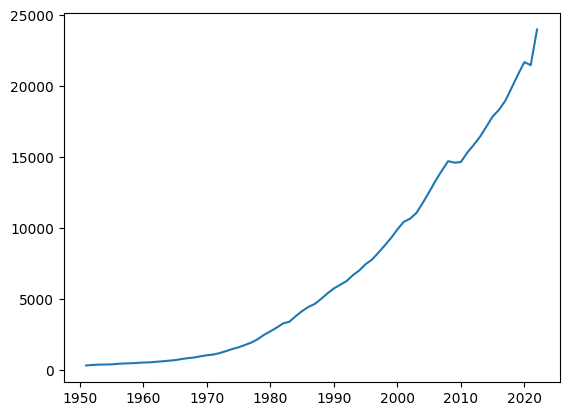

In [4]:
# draw the graph of GDP in time
plt.plot(df.Date, df.Value)

Series have several twists in overall trend in 2008 and 2020

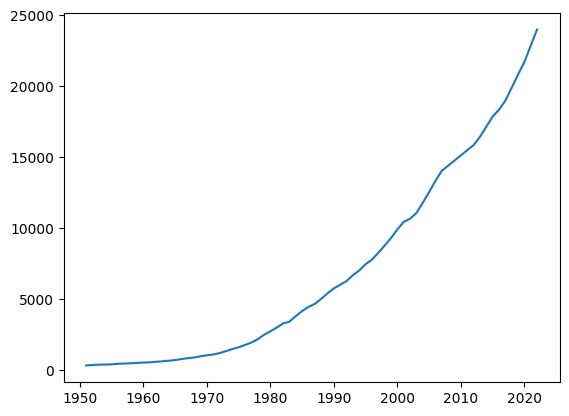

In [5]:
# let's change seeral values with Nan, since they are clogging up time series
# then we interpolate our series and plot the result
spisok = ["2007-12-31","2010-12-31","2008-12-31", "2009-12-31", "2020-12-31"]
for i in spisok:
    df.loc[df.Date==i, 'Value']=np.nan
df.Value = df.Value.interpolate()
plt.plot(df.Date, df.Value)

Now the plot of time series looks much smoother

In [6]:
# add t-variable for time trend and diide the sample into train and test one
df['t'] = range(1, df.shape[0]+1)
df_train = df.loc[df.Date.dt.year<2019, ]
df_test = df.drop(df_train.index)

In [7]:
# estimate simple OLS-regression GDP=a0+a1*t+a2*t^2+e
regr = smf.ols(data=df_train, formula = "Value~t+I(t**2)").fit()
print(regr.summary())

                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.840e+04
Date:                Sun, 29 Jan 2023   Prob (F-statistic):           1.36e-97
Time:                        14:59:38   Log-Likelihood:                -466.90
No. Observations:                  69   AIC:                             939.8
Df Residuals:                      66   BIC:                             946.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    803.3448     79.902     10.054      0.0

It's a common situation when regression model on time series has an autocorrelation in residuals and sometimes a heteroscedasticity; knowing that we conduct formal tests for detecting heteroscedasticity and autocorrelation

In [8]:
print("prob of non-heterosced:",sms.het_goldfeldquandt(y=regr.model.endog, x = regr.model.exog, alternative = 'two-sided', split=0.2)[1], "there is heteroscedasticity")
print("dw-stat:",sms.durbin_watson(regr.resid), "there is autocorrelation")

prob of non-heterosced: 4.656565176224098e-13 there is heteroscedasticity
dw-stat: 0.28998972337097517 there is autocorrelation


In [9]:
print('mape of approximation:',mape(df_train.Value, regr.fittedvalues))

mape of approximation: 0.1098555298191902


Mape of approximation is lower than 12%-15%, that's one of the indicators of good model

In [10]:
# we need to use rebust standard errors since there are a heteroscedasticity and an autocorrelation
print(regr.get_robustcov_results(cov_type='HAC', maxlags=1).summary())

                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.183e+04
Date:                Sun, 29 Jan 2023   Prob (F-statistic):           4.64e-85
Time:                        14:59:38   Log-Likelihood:                -466.90
No. Observations:                  69   AIC:                             939.8
Df Residuals:                      66   BIC:                             946.5
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    803.3448     98.252      8.176      0.0

We may see that t-statistics became slightly lower;
Let's make a prediction on test sample

In [11]:
predictions = regr.get_prediction(df_test)
p2 = predictions.summary_frame(alpha=0.05)
p2 = p2.drop(columns = ['mean_se'])
df_test.index = p2.index
p2['true_value'] = df_test.iloc[:,1]
p2['isinci'] = np.where((p2['true_value']<=p2['obs_ci_upper'])&(p2['true_value']>=p2['obs_ci_lower']), 1,0)
print('share of true GDP values from test sample inside the prediction confidence interval: ',p2.isinci.mean())

share of true GDP values from test sample inside the prediction confidence interval:  0.3333333333333333


Only 1/3 of true test values is in prediction confidence interval, so model is not adequate enough

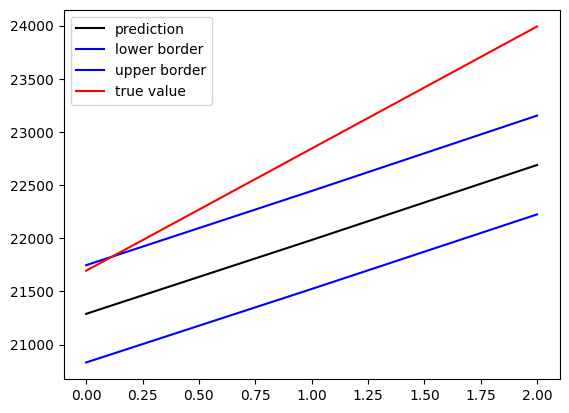

In [12]:
# plot prediction results
plt.plot(p2['mean'], label='prediction', color='black')
plt.plot(p2.obs_ci_lower, label='lower border', color='blue')
plt.plot(p2.obs_ci_upper, label='upper border', color='blue')
plt.plot(p2.true_value, label='true value', color='red')
plt.legend()
plt.show()

In [13]:
# calculate mean average precentage error
mape(p2['true_value'],p2['mean'] )

0.036897056607837715

As we may conclude, the model has good quality since the R-square is 0.999 and significant (p-value of F-test << 0.01). But model is not adequate since only 1/3 of true GDP values from test sample is inside the prediction confidence interval. However, the mape of prediction is quite low, about 3.7%, so the model can be generally used for predicting purposes, even though some of the Hauss-Markov biases are broken (but we corrected the covariance matrix of coefficients). The equation looks like this: GDP = 803.35 - 103.56*t + 5.66*t^2, R-sq=0.99  
Let's try to estimate a more "elevated" model such as Arima

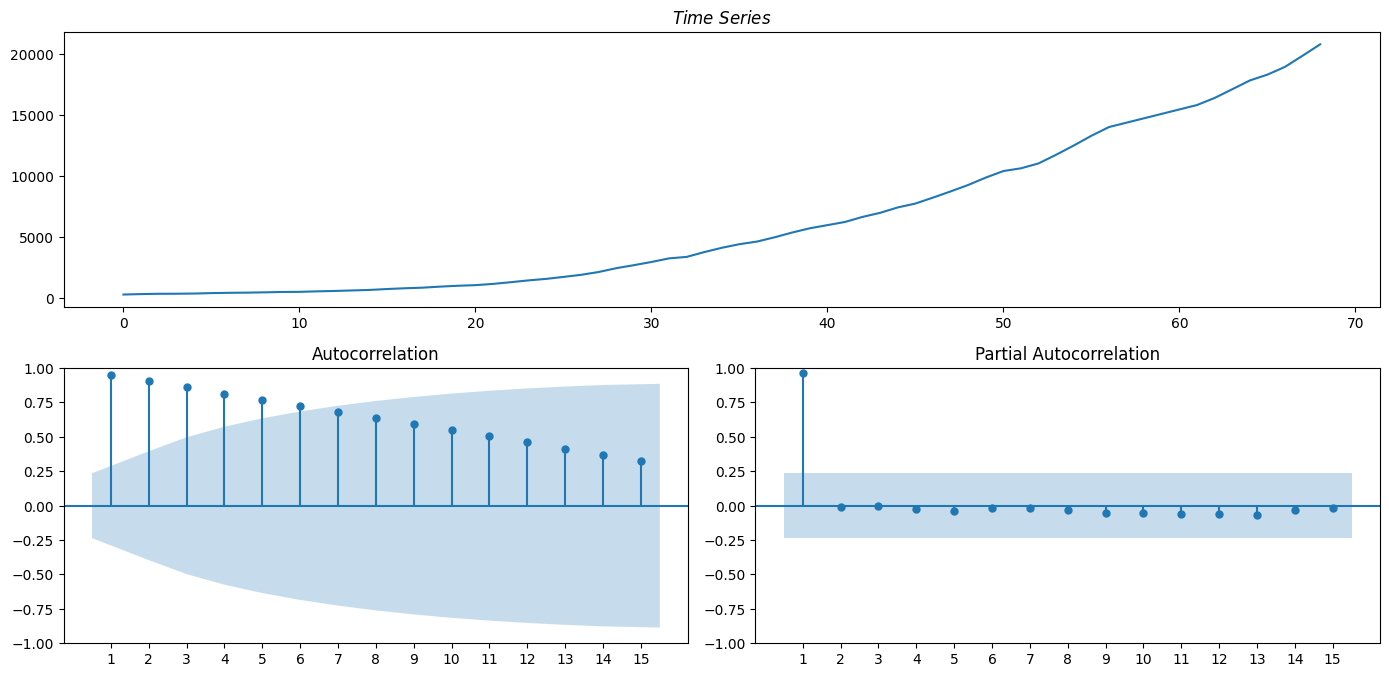

In [14]:
# let's plot the graph of series, and correlogramms
Arima_garch_forecasts.tsdisplay(df_train.Value, 15)

The data is obviously not stationary

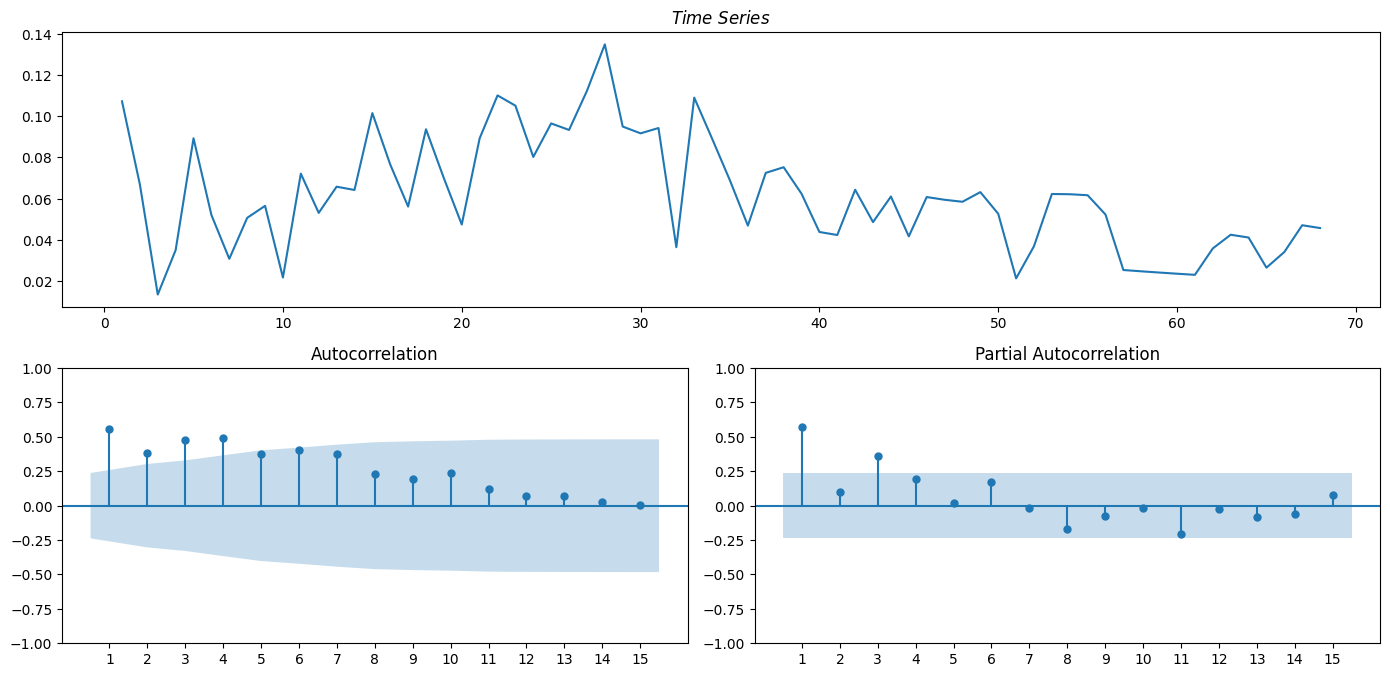

In [15]:
# let's use first differences of natural logarithms of Values, 
# since logarithm makes our data more linear, and differences make our data stationary
Arima_garch_forecasts.tsdisplay(np.log(df_train.Value).diff().dropna(), 15)

We may observe significant correlations on 1-4 lags, and significant partial correlations on 1st and 3rd lags, it's highly likely autoregressional process, not a moving average one

In [16]:
# test Dicky-Fuller for determining the stationarity of series, spoiler: they are, since p-value >> 0.1)
adfuller(np.log(df_train.Value).diff().dropna())

(-1.9611558649259113,
 0.303860183018791,
 2,
 65,
 {'1%': -3.5352168748293127,
  '5%': -2.9071540828402367,
  '10%': -2.5911025443786984},
 -276.7559288483901)

In [17]:
# how many diff lags can we use? Definitely - first lag!
ndiffs(np.log(df_train.Value).diff().dropna())

1

In [18]:
# let's create our own Arima model, ARIMA([1,3,4], 1, 0)
arima_1 = ARIMA(np.log(df_train.Value), order=((1,0,1,1),1,0)).fit()
print(arima_1.summary())

                                 SARIMAX Results                                  
Dep. Variable:                      Value   No. Observations:                   69
Model:             ARIMA([1, 3, 4], 1, 0)   Log Likelihood                 165.668
Date:                    Sun, 29 Jan 2023   AIC                           -323.337
Time:                            14:59:41   BIC                           -314.459
Sample:                                 0   HQIC                          -319.819
                                     - 69                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4238      0.099      4.279      0.000       0.230       0.618
ar.L3          0.2890      0.123      2.345      0.019       0.047       0.531
ar.L4          0.266

In [19]:
# let's estimate auto_arima model and compare with our own
arima_auto = auto_arima(np.log(df_train.Value))
print(arima_auto.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   69
Model:               SARIMAX(2, 2, 1)   Log Likelihood                 164.478
Date:                Sun, 29 Jan 2023   AIC                           -320.957
Time:                        14:59:43   BIC                           -312.138
Sample:                             0   HQIC                          -317.467
                                 - 69                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0334      0.249     -0.134      0.893      -0.521       0.454
ar.L2         -0.3595      0.159     -2.263      0.024      -0.671      -0.048
ma.L1         -0.5335      0.244     -2.188      0.0

In [20]:
# calculate forecasts
f1 = Arima_garch_forecasts.arima_forecast(arima_1, 0.05, np.log(df_test.Value))
f2 = Arima_garch_forecasts.arima_forecast(arima_auto, 0.05, np.log(df_test.Value))

In [21]:
print(mape(df_test.Value,np.exp(f1.fitted)))
print(mape(df_test.Value,np.exp(f2.fitted)))

0.01637781711571032
0.015422511988196844


Both mapes of prediction is quite low and better than that of regression model

Figure(640x480)
Figure(640x480)
Figure(640x480)


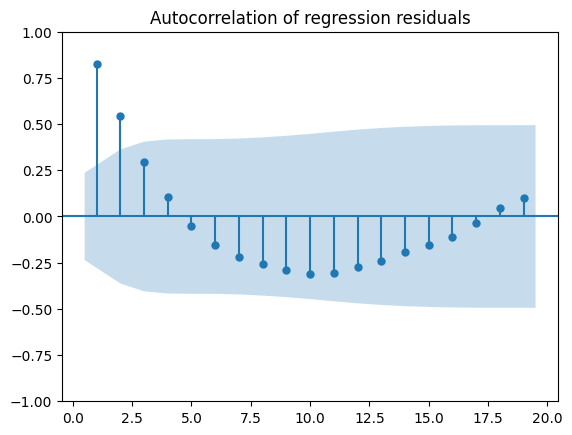

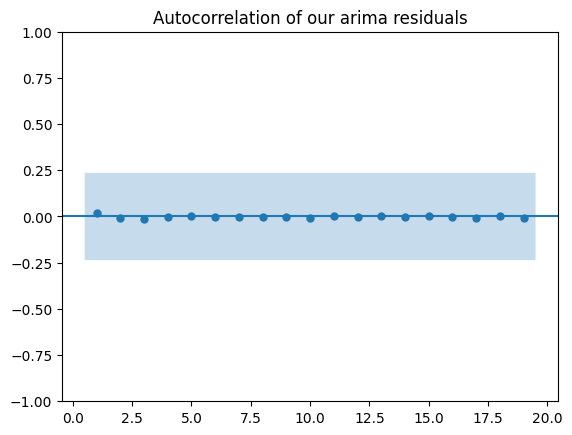

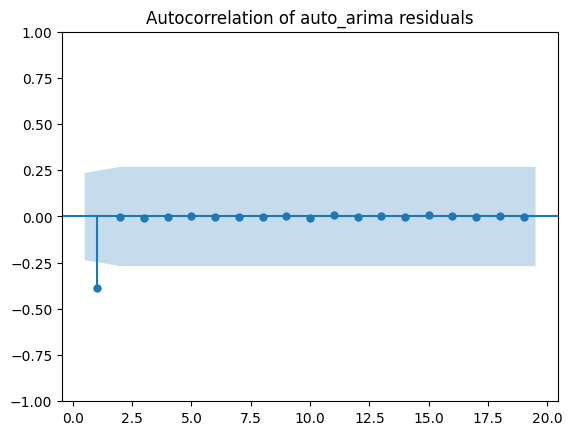

In [22]:
print(plot_acf(regr.resid, title='Autocorrelation of regression residuals', zero=0))
print(plot_acf(arima_1.resid, title='Autocorrelation of our arima residuals', zero=0))
print(plot_acf(arima_auto.resid(), title='Autocorrelation of auto_arima residuals', zero=0))

Only residuals from our arima model do not have autocorrelation, this fact means that we comprehensively described our data using our arima_1 model 

In [23]:
f1.index = range(df_train.index[-1]+1, df_train.index[-1]+2+f1.index[-1])
f2.index = range(df_train.index[-1]+1, df_train.index[-1]+2+f2.index[-1])

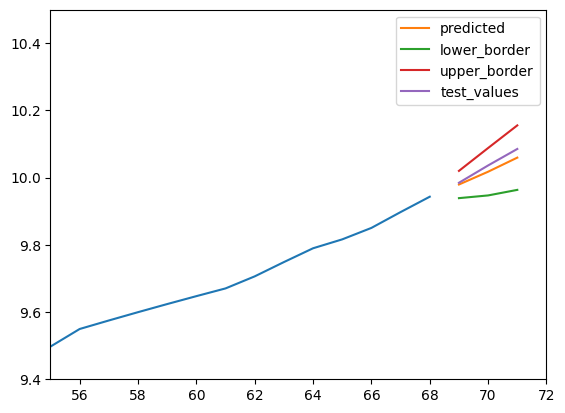

In [24]:
plt.plot(np.log(df_train.Value))
plt.plot(f1, label=['predicted', 'lower_border', 'upper_border', 'test_values'])
plt.xlim(55, f1.index[-1]+1)
plt.ylim(9.4,10.5)
plt.legend()
plt.show()

All the real test GDP values are in predictive intervals, so arima_1 is statistically adequate

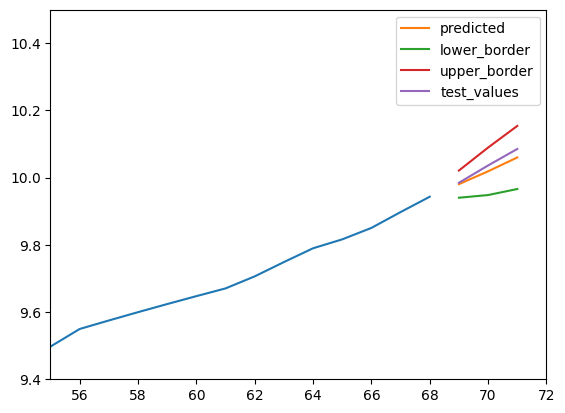

In [25]:
plt.plot(np.log(df_train.Value))
plt.plot(f2, label=['predicted', 'lower_border', 'upper_border', 'test_values'])
plt.xlim(55, f2.index[-1]+1)
plt.ylim(9.4,10.5)
plt.legend()
plt.show()

All the real test GDP values are in predictive intervals, so arima_auto is statistically adequate  
Let's think whethere we need to estimate garch model, which considers the variance  
Let's compute a formal test for determining arch effetc presence in the data

In [26]:
# arch test 
het_arch(np.log(df_train.Value).diff().dropna())

(30.980557074891344,
 0.0005910790943407926,
 5.389031100884688,
 2.8593126202958862e-05)

Since p-value of arch test is lower than significance level [0.01,0.05,0.1], there are arch effect in the series

In [27]:
garch = arch_model(y=np.log(df_train.Value).diff().dropna(), mean='AR', lags=[1,4], p=0,o=1,q=0).fit()
print(garch.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 224601893205585.53
Iteration:      2,   Func. Count:     19,   Neg. LLF: 141.08324392946975
Iteration:      3,   Func. Count:     29,   Neg. LLF: 433467013491549.56
Iteration:      4,   Func. Count:     41,   Neg. LLF: 517.7028116895904
Iteration:      5,   Func. Count:     51,   Neg. LLF: 957.6561461359024
Iteration:      6,   Func. Count:     60,   Neg. LLF: 609743335.8182505
Iteration:      7,   Func. Count:     72,   Neg. LLF: 252888989.21610153
Iteration:      8,   Func. Count:     82,   Neg. LLF: 36.18661309476825
Iteration:      9,   Func. Count:     91,   Neg. LLF: 4.187932344944846
Iteration:     10,   Func. Count:    100,   Neg. LLF: -148.0677506852274
Iteration:     11,   Func. Count:    107,   Neg. LLF: 28244859.08254783
Iteration:     12,   Func. Count:    114,   Neg. LLF: -140.30092343577934
Iteration:     13,   Func. Count:    122,   Neg. LLF: -161.75021752975536
Iteration:     14,   Func. Count:    129,   Neg. LLF: -

In [28]:
f3 = Arima_garch_forecasts.garch_forecast(garch, 0.05, df_train.Value, df_test.Value)
f3.index = range(df_train.index[-1]+1, df_train.index[-1]+2+f3.index[-1])
f3 = np.log(f3)

In [29]:
f3

,forecast,upper,lower,test
69,9.985454,10.018910,9.950841,9.984812
70,10.028210,10.097936,9.955961,10.036418
71,10.074618,10.180980,9.964340,10.085491


In [30]:
mape(df_test.Value, np.exp(f3.forecast))

0.006543411370088881

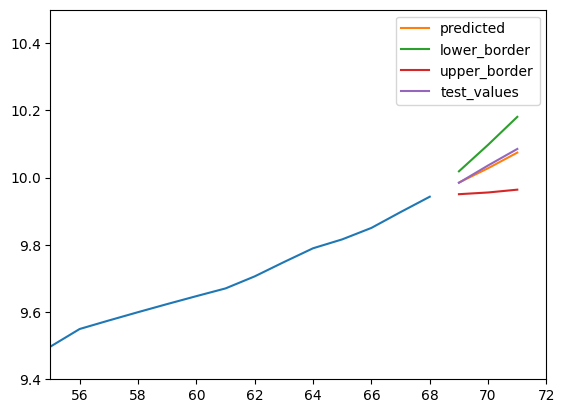

In [31]:
plt.plot(np.log(df_train.Value))
plt.plot(f3, label=['predicted', 'lower_border', 'upper_border', 'test_values'])
plt.xlim(55, f3.index[-1]+1)
plt.ylim(9.4,10.5)
plt.legend()
plt.show()

All the real test GDP values are in predictive intervals, so garch model is statistically adequate  
Moreover, mape of forecast is incomparably better than that of other models, so garch is the best model in this particular case  
Let's re-estimate the garch model on the whole dataframe and make a prediction for 2022-2024

In [32]:
garch_2 = arch_model(y=np.log(df.Value).diff().dropna(), mean='AR', lags=[1,4], p=0,o=1,q=0).fit()
print(garch.summary())

Iteration:      1,   Func. Count:      7,   Neg. LLF: 194116418323613.88
Iteration:      2,   Func. Count:     19,   Neg. LLF: 501250899.85023654
Iteration:      3,   Func. Count:     28,   Neg. LLF: 2001471491426525.5
Iteration:      4,   Func. Count:     40,   Neg. LLF: 153.92018829367123
Iteration:      5,   Func. Count:     50,   Neg. LLF: 200286236.63154885
Iteration:      6,   Func. Count:     58,   Neg. LLF: 1174040196325963.2
Iteration:      7,   Func. Count:     69,   Neg. LLF: -166.07480085016357
Optimization terminated successfully    (Exit mode 0)
            Current function value: -166.07480070914946
            Iterations: 11
            Function evaluations: 69
            Gradient evaluations: 7
                         AR - GJR-GARCH Model Results                         
Dep. Variable:                  Value   R-squared:                       0.423
Mean Model:                        AR   Adj. R-squared:                  0.404
Vol Model:                  GJR-GARCH   L

In [33]:
us_gdp_forecast = Arima_garch_forecasts.garch_forecast_without_test(garch_2, 0.05, df.Value, 3)
us_gdp_forecast.index = range(df.index[-1]+1, df.index[-1]+2+us_gdp_forecast.index[-1])

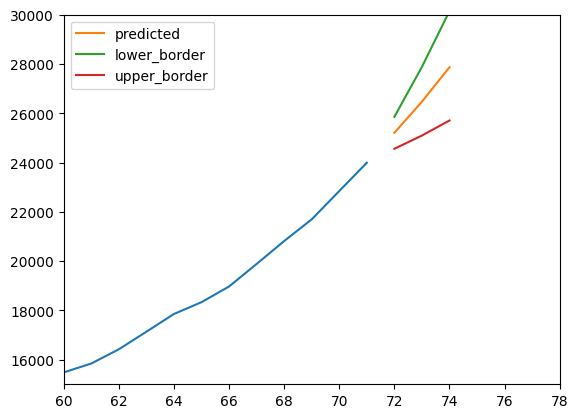

In [34]:
plt.plot(df.Value)
plt.plot(us_gdp_forecast, label=['predicted', 'lower_border', 'upper_border'])
plt.xlim(60, us_gdp_forecast.index[-1]+4)
plt.ylim(15000,30000)
plt.legend()
plt.show()

In [35]:
us_gdp_forecast

,forecast,upper,lower
72,25206.414290,25854.186406,24558.642174
73,26471.212264,27883.484362,25095.620245
74,27867.794409,30147.997560,25705.534908


As we see, according to the model, the US GDP will be 25206.41 bln dollars in 2022, 26471.21 bln in 2023, 27867.79 bln in 2024